In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import NearestCentroid,NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.utils.extmath import randomized_svd
from IPython.display import display
from numpy import linalg as la
from scipy.sparse import csr_matrix
pd.set_option('display.max_colwidth',None)
import os

In [4]:
users_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1JsWiGOpXta47kyP9QQMH7rskZAtmkZxg',sep=";",on_bad_lines="skip",encoding='latin-1')
ratings_df = pd.read_csv('https://drive.google.com/uc?export=download&id=1YrOExeh28DHW3djtgPdAxjaYOTaQDtFl',sep=";",on_bad_lines="skip",encoding='latin-1')
books_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1AsnxW_v4-J8F3ulQZF3Cvxtuk_13O5Jd",sep=";",on_bad_lines='skip',encoding = 'latin-1',low_memory = False)

In [5]:
print("Books dataframe shape: " , books_df.shape)
print("Ratings dataframe shape: " , ratings_df.shape)
print("Users dataframe shape: " , users_df.shape)

Books dataframe shape:  (271360, 8)
Ratings dataframe shape:  (1149780, 3)
Users dataframe shape:  (278858, 3)


In [6]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [7]:
ratings_df.head(5)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


PRE-PROCESSING

In [9]:
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


#### From the above result, we can see that location consists of city, state, country
#### So, we will filter out the attribute having data less than 3 values

In [10]:
# Getting the indices of location which is not equal to 3
drop_indeces = users_df[users_df['Location'].str.split(",").str.len() != 3].index

In [11]:
## Dropping the above indices
users_df = users_df.drop(index = drop_indeces)


In [12]:
## Computing the count whose location has all 3 values
(users_df['Location'].str.split(",").str.len()==3).value_counts()

Location
True    277348
Name: count, dtype: int64

In [13]:
users_df[['City','State','Country']] = users_df['Location'].str.strip().str.split(",",expand = True,n=2)

In [14]:
users_df['City'] = users_df['City'].str.strip()
users_df['State'] = users_df['State'].str.strip()
users_df['Country'] = users_df['Country'].str.strip()

In [15]:
users_df.head()

,User-ID,Location,Age,City,State,Country
0,1,"nyc, new york, usa",NaN,nyc,new york,usa
1,2,"stockton, california, usa",18.0,stockton,california,usa
2,3,"moscow, yukon territory, russia",NaN,moscow,yukon territory,russia
3,4,"porto, v.n.gaia, portugal",17.0,porto,v.n.gaia,portugal
4,5,"farnborough, hants, united kingdom",NaN,farnborough,hants,united kingdom


#### Dropping column 'Location' as it is split into (City,State,Country) columns

In [16]:
users_df = users_df.drop('Location',axis = 1)
users_df

,User-ID,Age,City,State,Country
0,1,NaN,nyc,new york,usa
1,2,18.0,stockton,california,usa
2,3,NaN,moscow,yukon territory,russia
3,4,17.0,porto,v.n.gaia,portugal
4,5,NaN,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,NaN,portland,oregon,usa
278854,278855,50.0,tacoma,washington,united kingdom
278855,278856,NaN,brampton,ontario,canada
278856,278857,NaN,knoxville,tennessee,usa


In [17]:
users_df['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,   2.,  70.,  77.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

## Also we are considering age group between 10 to 90 to get more appropriate data

In [18]:
users_df[~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()]['Age'].unique()

array([  0.,   1.,   9., 103., 104., 231.,   3., 119.,   2.,  93.,   8.,
         7.,   4., 114., 230., 239.,   5., 148., 151.,   6., 101., 201.,
        96., 123., 244., 133.,  91., 128.,  94., 141., 110.,  97., 219.,
       124.,  92., 175., 172., 209., 212., 237., 162., 100., 156., 136.,
        95., 106.,  99., 108., 210., 199., 147., 168., 132., 159., 186.,
       152., 102., 116., 200., 115., 226., 137., 207., 229., 138., 109.,
       105., 228., 183., 204.,  98., 223., 113., 208., 157., 111., 146.,
       118., 220., 143., 140., 189., 127.])

Text(0, 0.5, 'Frequency')

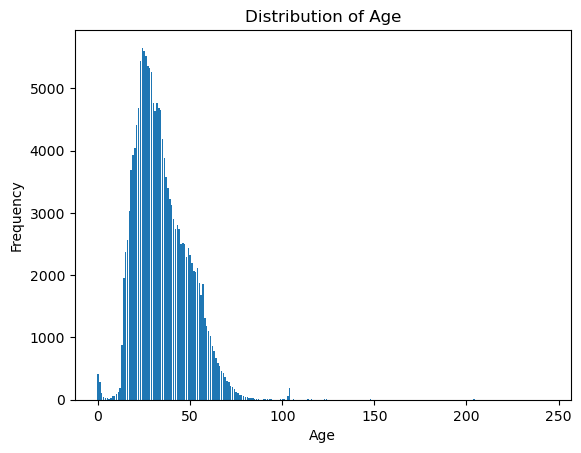

In [19]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

#### Filtering the age group as mentioned

In [20]:
users_to_omit = ~users_df['Age'].between(10,90) & ~users_df['Age'].isnull()
users_df.loc[users_to_omit] = np.nan
users_df['Age'].sort_values().unique()

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
       23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.,
       36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48.,
       49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61.,
       62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 87.,
       88., 89., 90., nan])

In [21]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,NaN,nyc,new york,usa
1,2.0,18.0,stockton,california,usa
2,3.0,NaN,moscow,yukon territory,russia
3,4.0,17.0,porto,v.n.gaia,portugal
4,5.0,NaN,farnborough,hants,united kingdom


In [22]:
users_df['Age'].mean()

34.729518290474466

#### Imputing age column with the mean age value of 34

In [23]:
null_age = users_df['Age'].isnull()
users_df.loc[null_age,'Age'] = users_df['Age'].mean()

<BarContainer object of 82 artists>

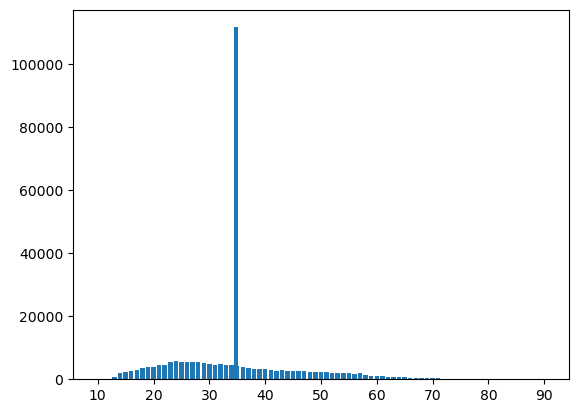

In [24]:
ages_graph_params = users_df.groupby('Age').size()
plt.bar(ages_graph_params.index,ages_graph_params.values)


In [25]:
users_df.head()

,User-ID,Age,City,State,Country
0,1.0,34.729518,nyc,new york,usa
1,2.0,18.000000,stockton,california,usa
2,3.0,34.729518,moscow,yukon territory,russia
3,4.0,17.000000,porto,v.n.gaia,portugal
4,5.0,34.729518,farnborough,hants,united kingdom


In [26]:
users_df['Age'] = users_df['Age'].astype('int')

In [27]:
users_df['Age'].sort_values().unique()

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90])

#### Column country has garbage and reduntant values

In [28]:
users_df['Country'].sort_values().unique()

array(['', '"', '&#20013;&#22269;', '&#32654;&#22269;', '*', '-',
       '-------', '.', '01776', '02458', '19104', '23232', '30064',
       '5057chadwick ct.', '85021', '87510', '?ú?{', '\\"n/a\\""',
       '\\n/a\\""', '_ brasil', 'a', 'aaa', 'adsgfdr',
       'afganstand holla !!', 'afghanistan', 'ahrensburg', 'alachua',
       'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra',
       'america', 'american samoa', 'andorra', 'andorra"', 'angola',
       'antarctica', 'antigua & barbuda', 'antigua and barbuda',
       'aotearoa', 'argentina', 'argentina"', 'armenia', 'aroostook',
       'aruba', 'asturies', 'auckland', 'australia', 'australia"',
       'australii', 'austria', 'austria"', 'autralia', 'az', 'azerbaijan',
       'bademn würtemberg', 'baden-württemberg', 'bahamas', 'bahrain',
       'baltimore', 'bangladesh', 'bangladesh"', 'barbados', 'basilicata',
       'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus',
       'belgi', 'belgique', 'belgium', 

#### We are using list of countries from this link for filtering out users.

In [29]:
countries = (
    ('AF', 'AFGHANISTAN'),
    ('AL', 'ALBANIA'),
    ('DZ', 'ALGERIA'),
    ('AS', 'AMERICAN SAMOA'),
    ('AD', 'ANDORRA'),
    ('AO', 'ANGOLA'),
    ('AI', 'ANGUILLA'),
    ('AQ', 'ANTARCTICA'),
    ('AG', 'ANTIGUA AND BARBUDA'),
    ('AR', 'ARGENTINA'),
    ('AM', 'ARMENIA'),
    ('AW', 'ARUBA'),
    ('AU', 'AUSTRALIA'),
    ('AT', 'AUSTRIA'),
    ('AZ', 'AZERBAIJAN'),
    ('BS', 'BAHAMAS'),
    ('BH', 'BAHRAIN'),
    ('BD', 'BANGLADESH'),
    ('BB', 'BARBADOS'),
    ('BY', 'BELARUS'),
    ('BE', 'BELGIUM'),
    ('BZ', 'BELIZE'),
    ('BJ', 'BENIN'),
    ('BM', 'BERMUDA'),
    ('BT', 'BHUTAN'),
    ('BO', 'BOLIVIA'),
    ('BA', 'BOSNIA AND HERZEGOVINA'),
    ('BW', 'BOTSWANA'),
    ('BV', 'BOUVET ISLAND'),
    ('BR', 'BRAZIL'),
    ('IO', 'BRITISH INDIAN OCEAN TERRITORY'),
    ('BN', 'BRUNEI DARUSSALAM'),
    ('BG', 'BULGARIA'),
    ('BF', 'BURKINA FASO'),
    ('BI', 'BURUNDI'),
    ('KH', 'CAMBODIA'),
    ('CM', 'CAMEROON'),
    ('CA', 'CANADA'),
    ('CV', 'CAPE VERDE'),
    ('KY', 'CAYMAN ISLANDS'),
    ('CF', 'CENTRAL AFRICAN REPUBLIC'),
    ('TD', 'CHAD'),
    ('CL', 'CHILE'),
    ('CN', 'CHINA'),
    ('CX', 'CHRISTMAS ISLAND'),
    ('CC', 'COCOS (KEELING) ISLANDS'),
    ('CO', 'COLOMBIA'),
    ('KM', 'COMOROS'),
    ('CG', 'CONGO'),
    ('CD', 'CONGO, THE DEMOCRATIC REPUBLIC OF'),
    ('CK', 'COOK ISLANDS'),
    ('CR', 'COSTA RICA'),
    ('CI', "CÃ”TE D'IVOIRE"),
    ('HR', 'CROATIA'),
    ('CU', 'CUBA'),
    ('CY', 'CYPRUS'),
    ('CZ', 'CZECH REPUBLIC'),
    ('DK', 'DENMARK'),
    ('DJ', 'DJIBOUTI'),
    ('DM', 'DOMINICA'),
    ('DO', 'DOMINICAN REPUBLIC'),
    ('EC', 'ECUADOR'),
    ('EG', 'EGYPT'),
    ('SV', 'EL SALVADOR'),
    ('GQ', 'EQUATORIAL GUINEA'),
    ('ER', 'ERITREA'),
    ('EE', 'ESTONIA'),
    ('ET', 'ETHIOPIA'),
    ('FK', 'FALKLAND ISLANDS (MALVINAS)'),
    ('FO', 'FAROE ISLANDS'),
    ('FJ', 'FIJI'),
    ('FI', 'FINLAND'),
    ('FR', 'FRANCE'),
    ('GF', 'FRENCH GUIANA'),
    ('PF', 'FRENCH POLYNESIA'),
    ('TF', 'FRENCH SOUTHERN TERRITORIES'),
    ('GA', 'GABON'),
    ('GM', 'GAMBIA'),
    ('GE', 'GEORGIA'),
    ('DE', 'GERMANY'),
    ('GH', 'GHANA'),
    ('GI', 'GIBRALTAR'),
    ('GR', 'GREECE'),
    ('GL', 'GREENLAND'),
    ('GD', 'GRENADA'),
    ('GP', 'GUADELOUPE'),
    ('GU', 'GUAM'),
    ('GT', 'GUATEMALA'),
    ('GN', 'GUINEA'),
    ('GW', 'GUINEA'),
    ('GY', 'GUYANA'),
    ('HT', 'HAITI'),
    ('HM', 'HEARD ISLAND AND MCDONALD ISLANDS'),
    ('HN', 'HONDURAS'),
    ('HK', 'HONG KONG'),
    ('HU', 'HUNGARY'),
    ('IS', 'ICELAND'),
    ('IN', 'INDIA'),
    ('ID', 'INDONESIA'),
    ('IR', 'IRAN, ISLAMIC REPUBLIC OF'),
    ('IQ', 'IRAQ'),
    ('IE', 'IRELAND'),
    ('IL', 'ISRAEL'),
    ('IT', 'ITALY'),
    ('JM', 'JAMAICA'),
    ('JP', 'JAPAN'),
    ('JO', 'JORDAN'),
    ('KZ', 'KAZAKHSTAN'),
    ('KE', 'KENYA'),
    ('KI', 'KIRIBATI'),
    ('KP', "KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF"),
    ('KR', 'KOREA, REPUBLIC OF'),
    ('KW', 'KUWAIT'),
    ('KG', 'KYRGYZSTAN'),
    ('LA', "LAO PEOPLE'S DEMOCRATIC REPUBLIC"),
    ('LV', 'LATVIA'),
    ('LB', 'LEBANON'),
    ('LS', 'LESOTHO'),
    ('LR', 'LIBERIA'),
    ('LY', 'LIBYAN ARAB JAMAHIRIYA'),
    ('LI', 'LIECHTENSTEIN'),
    ('LT', 'LITHUANIA'),
    ('LU', 'LUXEMBOURG'),
    ('MO', 'MACAO'),
    ('MK', 'MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF'),
    ('MG', 'MADAGASCAR'),
    ('MW', 'MALAWI'),
    ('MY', 'MALAYSIA'),
    ('MV', 'MALDIVES'),
    ('ML', 'MALI'),
    ('MT', 'MALTA'),
    ('MH', 'MARSHALL ISLANDS'),
    ('MQ', 'MARTINIQUE'),
    ('MR', 'MAURITANIA'),
    ('MU', 'MAURITIUS'),
    ('YT', 'MAYOTTE'),
    ('MX', 'MEXICO'),
    ('FM', 'MICRONESIA, FEDERATED STATES OF'),
    ('MD', 'MOLDOVA, REPUBLIC OF'),
    ('MC', 'MONACO'),
    ('MN', 'MONGOLIA'),
    ('MS', 'MONTSERRAT'),
    ('MA', 'MOROCCO'),
    ('MZ', 'MOZAMBIQUE'),
    ('MM', 'MYANMAR'),
    ('NA', 'NAMIBIA'),
    ('NR', 'NAURU'),
    ('NP', 'NEPAL'),
    ('NL', 'NETHERLANDS'),
    ('AN', 'NETHERLANDS ANTILLES'),
    ('NC', 'NEW CALEDONIA'),
    ('NZ', 'NEW ZEALAND'),
    ('NI', 'NICARAGUA'),
    ('NE', 'NIGER'),
    ('NG', 'NIGERIA'),
    ('NU', 'NIUE'),
    ('NF', 'NORFOLK ISLAND'),
    ('MP', 'NORTHERN MARIANA ISLANDS'),
    ('NO', 'NORWAY'),
    ('OM', 'OMAN'),
    ('PK', 'PAKISTAN'),
    ('PW', 'PALAU'),
    ('PS', 'PALESTINIAN TERRITORY, OCCUPIED'),
    ('PA', 'PANAMA'),
    ('PG', 'PAPUA NEW GUINEA'),
    ('PY', 'PARAGUAY'),
    ('PE', 'PERU'),
    ('PH', 'PHILIPPINES'),
    ('PN', 'PITCAIRN'),
    ('PL', 'POLAND'),
    ('PT', 'PORTUGAL'),
    ('PR', 'PUERTO RICO'),
    ('QA', 'QATAR'),
    ('RE', 'RÃ‰UNION'),
    ('RO', 'ROMANIA'),
    ('RU', 'RUSSIAN FEDERATION'),
    ('RW', 'RWANDA'),
    ('SH', 'SAINT HELENA'),
    ('KN', 'SAINT KITTS AND NEVIS'),
    ('LC', 'SAINT LUCIA'),
    ('PM', 'SAINT PIERRE AND MIQUELON'),
    ('VC', 'SAINT VINCENT AND THE GRENADINES'),
    ('WS', 'SAMOA'),
    ('SM', 'SAN MARINO'),
    ('ST', 'SAO TOME AND PRINCIPE'),
    ('SA', 'SAUDI ARABIA'),
    ('SN', 'SENEGAL'),
    ('CS', 'SERBIA AND MONTENEGRO'),
    ('SC', 'SEYCHELLES'),
    ('SL', 'SIERRA LEONE'),
    ('SG', 'SINGAPORE'),
    ('SK', 'SLOVAKIA'),
    ('SI', 'SLOVENIA'),
    ('SB', 'SOLOMON ISLANDS'),
    ('SO', 'SOMALIA'),
    ('ZA', 'SOUTH AFRICA'),
    ('GS', 'SOUTH GEORGIA AND SOUTH SANDWICH ISLANDS'),
    ('ES', 'SPAIN'),
    ('LK', 'SRI LANKA'),
    ('SD', 'SUDAN'),
    ('SR', 'SURINAME'),
    ('SJ', 'SVALBARD AND JAN MAYEN'),
    ('SZ', 'SWAZILAND'),
    ('SE', 'SWEDEN'),
    ('CH', 'SWITZERLAND'),
    ('SY', 'SYRIAN ARAB REPUBLIC'),
    ('TW', 'TAIWAN, PROVINCE OF CHINA'),
    ('TJ', 'TAJIKISTAN'),
    ('TZ', 'TANZANIA, UNITED REPUBLIC OF'),
    ('TH', 'THAILAND'),
    ('TL', 'TIMOR'),
    ('TG', 'TOGO'),
    ('TK', 'TOKELAU'),
    ('TO', 'TONGA'),
    ('TT', 'TRINIDAD AND TOBAGO'),
    ('TN', 'TUNISIA'),
    ('TR', 'TURKEY'),
    ('TM', 'TURKMENISTAN'),
    ('TC', 'TURKS AND CAICOS ISLANDS'),
    ('TV', 'TUVALU'),
    ('UG', 'UGANDA'),
    ('UA', 'UKRAINE'),
    ('AE', 'UNITED ARAB EMIRATES'),
    ('GB', 'UNITED KINGDOM'),
    ('US', 'UNITED STATES'),
    ('UM', 'UNITED STATES MINOR OUTLYING ISLANDS'),
    ('UY', 'URUGUAY'),
    ('UZ', 'UZBEKISTAN'),
    ('VU', 'VANUATU'),
    ('VN', 'VIET NAM'),
    ('VG', 'VIRGIN ISLANDS, BRITISH'),
    ('VI', 'VIRGIN ISLANDS, U.S.'),
    ('WF', 'WALLIS AND FUTUNA'),
    ('EH', 'WESTERN SAHARA'),
    ('YE', 'YEMEN'),
    ('ZW', 'ZIMBABWE')
)

In [30]:
list_of_countries = []
for i in countries:
    list_of_countries.append(i[1].lower())

In [31]:
print(list_of_countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antarctica', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'brazil', 'british indian ocean territory', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos (keeling) islands', 'colombia', 'comoros', 'congo', 'congo, the democratic republic of', 'cook islands', 'costa rica', "cã”te d'ivoire", 'croatia', 'cuba', 'cyprus', 'czech republic', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'falkland islands (malvinas)', 'faroe islands

#### Filtering users based on our list_of_countries values

In [32]:
users_df = users_df[users_df['Country'].isin(list_of_countries)]
users_df

,User-ID,Age,City,State,Country
3,4.0,17,porto,v.n.gaia,portugal
4,5.0,34,farnborough,hants,united kingdom
7,8.0,34,timmins,ontario,canada
9,10.0,26,albacete,wisconsin,spain
10,11.0,14,melbourne,victoria,australia
...,...,...,...,...,...
278851,278852.0,32,brisbane,queensland,australia
278852,278853.0,17,stranraer,n/a,united kingdom
278854,278855.0,50,tacoma,washington,united kingdom
278855,278856.0,34,brampton,ontario,canada


#### Now selecting states and cities with atleast 4 characters and filtering it out with junk characters

In [33]:
list_of_states = users_df['State'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()

In [34]:
users_df = users_df[users_df['State'].isin(list_of_states)]

In [35]:
list_of_city = users_df['City'].str.extract(r'(^[a-z]{4}[a-z]*|^[a-z]{1}[a-z]*\w[a-z]{4})')[0].unique()
users_df = users_df[users_df['City'].isin(list_of_city)]

In [36]:
print("Unique country count: " , users_df['Country'].nunique())
print("Unique state count: " ,users_df['State'].nunique())
print("Unique City count: " , users_df['City'].nunique())

Unique country count:  154
Unique state count:  2192
Unique City count:  8452


#### Filtering the books dataset. Removing unrelated attributes

In [37]:
books_df.head(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [38]:
books_df = books_df.drop(['Image-URL-S','Image-URL-M','Image-URL-L'],axis = 1)
books_df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [39]:
books_df['Year-Of-Publication'].unique()


array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1983', '1979', '1995',
       '1982', '1985', '1992', '1986', '1978', '1980', '1952', '1987',
       '1990', '1981', '1989', '1984', '0', '1968', '1961', '1958',
       '1974', '1976', '1971', '1977', '1975', '1965', '1941', '1970',
       '1962', '1973', '1972', '1960', '1966', '1920', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1954', '1950',
       '1967', '2005', '1957', '1940', '1937', '1955', '1946', '1936',
       '1930', '2011', '1925', '1948', '1943', '1947', '1945', '1923',
       '2020', '1939', '1926', '1938', '2030', '1911', '1904', '1949',
       '1932', '1928', '1929', '1927', '1931', '1914', '2050', '1934',
       '1910', '1933', '1902', '1924', '1921', '1900', '2038', '2026',
       '1944', '1917', '1901', '2010', '1908', '1906', '1935', '1806',
       '2021', '2012', '2006', 'DK Publishing Inc', 'Gallimard', '1909',
       

In [40]:
year_of_publication = books_df['Year-Of-Publication'].str.extract(r'(\d{4})')[0]
books_df = books_df[books_df['Year-Of-Publication'].isin(year_of_publication)]

In [41]:
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6812\406188384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype('int')


In [42]:
books_df['Year-Of-Publication'].unique()


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378, 1919,
       1922, 1897, 2024, 1376, 2037])

#### Lets Check Ratings Datafram

In [43]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [44]:
sorted(ratings_df['Book-Rating'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Text(0, 0.5, 'Frequency')

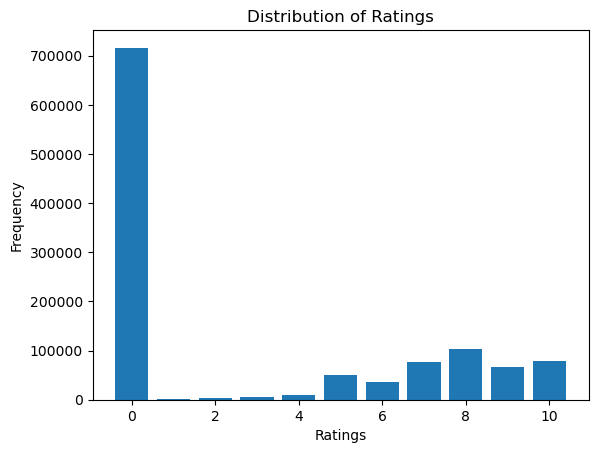

In [45]:
ratings_group = ratings_df.groupby('Book-Rating').size()
plt.bar(ratings_group.index,ratings_group.values)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

In [46]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [47]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266739 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 266739 non-null  object
 1   Book-Title           266739 non-null  object
 2   Book-Author          266737 non-null  object
 3   Year-Of-Publication  266739 non-null  int32 
 4   Publisher            266737 non-null  object
dtypes: int32(1), object(4)
memory usage: 11.2+ MB


In [48]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69301 entries, 4 to 278855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User-ID  69301 non-null  float64
 1   Age      69301 non-null  int32  
 2   City     69301 non-null  object 
 3   State    69301 non-null  object 
 4   Country  69301 non-null  object 
dtypes: float64(1), int32(1), object(3)
memory usage: 2.9+ MB


#### Merging Users,Books,Ratings dataframe for our dataset

In [49]:
dataset = ratings_df.merge(books_df,on = 'ISBN').merge(users_df,how='inner',on='User-ID')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   User-ID              132920 non-null  int64 
 1   ISBN                 132920 non-null  object
 2   Book-Rating          132920 non-null  int64 
 3   Book-Title           132920 non-null  object
 4   Book-Author          132919 non-null  object
 5   Year-Of-Publication  132920 non-null  int32 
 6   Publisher            132920 non-null  object
 7   Age                  132920 non-null  int32 
 8   City                 132920 non-null  object
 9   State                132920 non-null  object
 10  Country              132920 non-null  object
dtypes: int32(2), int64(2), object(7)
memory usage: 10.1+ MB


#### Dropping the duplicate user-ID and ISBN rows as a user can have only one rating per book.

In [50]:
dataset = dataset.drop_duplicates(['User-ID','ISBN'],keep='first')
dataset.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,34,melaka,melaka,malaysia
1,77940,0671793489,0,All Around the Town,Mary Higgins Clark,1993,Pocket Star,34,melaka,melaka,malaysia
2,77940,0553586122,0,Reap the Wind,Iris Johansen,2002,Bantam Books,34,melaka,melaka,malaysia
3,77940,055358068X,0,The Least Likely Bride,Jane Feather,2000,Bantam,34,melaka,melaka,malaysia
4,77940,0743422732,0,High Country Bride (McKettrick Cowboys),Linda Lael Miller,2002,Pocket,34,melaka,melaka,malaysia


In [51]:
dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].sample(10)

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
46060,0,James Patterson,2002,Warner Vision,25,vienna,vienna,austria
119320,0,John Beardshaw,1989,Trans-Atlantic Publications,31,daventry,england,united kingdom
78593,0,Rich Shapero,2004,Too Far,21,dunedin,otago,new zealand
100665,8,Mary Bray Pipher,1999,Putnam Pub Group,34,dalkeith,ontario,canada
78341,7,Henriette Roland Holst-Van der Schalk,1979,Arbeiderspers,40,enschede,overijssel,netherlands
46865,5,Stephen King,1986,Signet Book,38,kyoto,kyoto,japan
131648,0,Utta Danella,2002,Goldmann,15,lengenfeld,sachsen,germany
83954,0,SOPHIE KINSELLA,2001,Delta,30,blairmore,alberta,canada
28168,0,Rosamunde Pilcher,1999,WUNDERLICH VLG.,34,wien,wien,austria
52228,0,Duncan Kyle,1987,HarperCollins Publishers,47,toronto,ontario,canada


#### Selecting the required columns for training

In [52]:
recomendation_dataset = dataset[['Book-Rating','Book-Author','Year-Of-Publication','Publisher','Age','City','State','Country']].copy()
recomendation_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132920 entries, 0 to 132919
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Book-Rating          132920 non-null  int64 
 1   Book-Author          132919 non-null  object
 2   Year-Of-Publication  132920 non-null  int32 
 3   Publisher            132920 non-null  object
 4   Age                  132920 non-null  int32 
 5   City                 132920 non-null  object
 6   State                132920 non-null  object
 7   Country              132920 non-null  object
dtypes: int32(2), int64(1), object(5)
memory usage: 7.1+ MB


#### Label encoding all catecorical columns

In [53]:
encoder = LabelEncoder()
for column in recomendation_dataset.columns:
    if recomendation_dataset[column].dtype == object:
        recomendation_dataset[column] = encoder.fit_transform(recomendation_dataset[column])


In [54]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0,19612,2002,509,34,1645,405,50
1,0,21072,1993,4719,34,1645,405,50
2,0,12763,2002,521,34,1645,405,50
3,0,13844,2000,519,34,1645,405,50
4,0,18838,2002,4712,34,1645,405,50
...,...,...,...,...,...,...,...,...
132915,0,12627,2003,1889,24,2885,15,76
132916,0,14219,2001,2420,50,2909,757,79
132917,6,16965,2004,6340,41,59,496,16
132918,0,29771,2000,231,27,2675,706,6


#### Normalizing every column to range between 0 and 1

In [55]:
def normalizer(data,min,max):
    return (data - min) / (max - min)

In [56]:
for column in recomendation_dataset.columns:
    min = recomendation_dataset[column].min()
    max = recomendation_dataset[column].max()
    recomendation_dataset[column] = recomendation_dataset[column].apply(normalizer,args=(min,max))


In [57]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451
...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934


#### KMeans

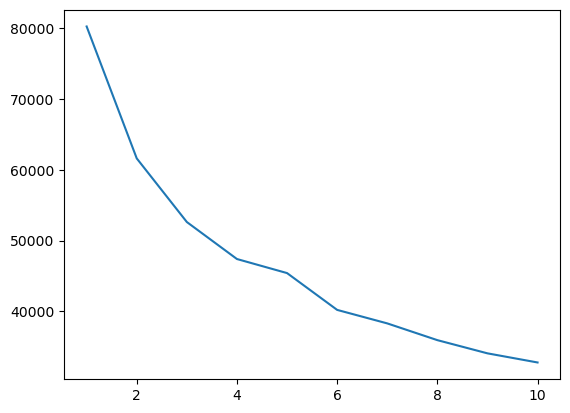

In [58]:
inertias = []
for i in range(1,11):
    km = KMeans(n_clusters = i,n_init = 'auto')
    km.fit(recomendation_dataset)
    inertias.append(km.inertia_)
plt.plot(range(1,11),inertias)


In [59]:
kmeans = KMeans(n_clusters= 5,n_init = 'auto')
clusters = kmeans.fit_predict(recomendation_dataset)


#### Appending cluster values back to our training dataset

In [60]:
recomendation_dataset['Clusters'] = clusters

In [61]:
recomendation_dataset['Clusters'].value_counts()

Clusters
1    38288
4    27886
2    26481
3    21612
0    18653
Name: count, dtype: int64

In [62]:
recomendation_dataset

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
0,0.0,0.603799,0.675676,0.076118,0.3000,0.565486,0.535007,0.549451,2
1,0.0,0.648748,0.614865,0.705698,0.3000,0.565486,0.535007,0.549451,2
2,0.0,0.392937,0.675676,0.077912,0.3000,0.565486,0.535007,0.549451,2
3,0.0,0.426218,0.662162,0.077613,0.3000,0.565486,0.535007,0.549451,2
4,0.0,0.579970,0.675676,0.704651,0.3000,0.565486,0.535007,0.549451,2
...,...,...,...,...,...,...,...,...,...
132915,0.0,0.388750,0.682432,0.282488,0.1750,0.991750,0.019815,0.835165,2
132916,0.0,0.437764,0.668919,0.361896,0.5000,1.000000,1.000000,0.868132,2
132917,0.6,0.522305,0.689189,0.948108,0.3875,0.020282,0.655218,0.175824,4
132918,0.0,0.916567,0.662162,0.034545,0.2125,0.919560,0.932629,0.065934,1


#### Selecting training and test data

In [63]:
train_df,test_df = recomendation_dataset.iloc[:,:-1],recomendation_dataset.iloc[:,-1]

#### Splitting training and testing dataset

In [64]:
train_X,test_x,train_y,test_y = train_test_split(train_df,test_df,test_size=0.2)

#### ROCCHIO CLASSIFIER

#### Creating an instance of Rocchio classifier

In [65]:
rocchio_clf = NearestCentroid()
rocchio_clf.fit(train_X,train_y)

NearestCentroid()

#### Checking the correctness and accuracy of rocchio method using cross validation

In [66]:
print(cross_val_score(rocchio_clf,train_df,test_df,cv = 5))

[0.9916115  0.99582456 0.997743   0.99195005 0.99631357]


#### Predicting results

In [67]:
pred_y = rocchio_clf.predict(test_x)

In [68]:
accuracy_score(test_y,pred_y) * 100

99.9285284381583

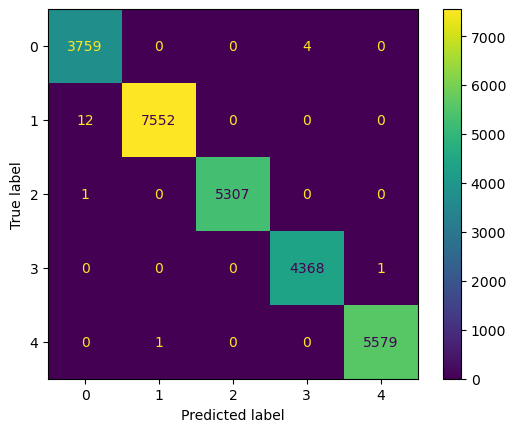

In [69]:
cm = confusion_matrix(test_y,pred_y)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#### Taking some samples for recomendation

In [70]:
samples = test_x.sample(10)
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
67166,1.0,0.934546,0.513514,0.679827,0.3000,0.525610,0.261559,0.956044
131072,0.0,0.737724,0.628378,0.238074,0.2250,0.919560,0.066050,0.065934
101118,1.0,0.785536,0.668919,0.885449,0.3000,0.126504,0.261559,0.956044
91998,0.0,0.776269,0.493243,0.066248,0.3000,0.102441,0.019815,0.175824
35707,0.0,0.435270,0.648649,0.704651,0.2500,0.525610,0.655218,0.175824
65632,0.7,0.674948,0.574324,0.011664,0.3500,0.525610,0.261559,0.956044
132745,0.0,0.694283,0.689189,0.729026,0.0250,0.643176,0.261559,0.956044
61581,0.0,0.583787,0.668919,0.703754,0.1875,0.155036,0.019815,0.175824
103434,0.5,0.214371,0.641892,0.394945,0.3375,0.003781,0.947160,0.956044
115967,0.0,0.644992,0.668919,0.238223,0.5375,0.089722,0.107001,0.868132


In [71]:
indeces = samples.index.tolist()
indeces

[67166, 131072, 101118, 91998, 35707, 65632, 132745, 61581, 103434, 115967]

#### Predicting cluster values for our sample values

In [72]:
samples_pred = rocchio_clf.predict(samples).reshape(1,-1).flatten().tolist()
samples_pred

[3, 1, 3, 0, 1, 3, 2, 0, 3, 2]

In [73]:
data = train_X.copy()

In [74]:
data['Clusters'] = train_y

In [75]:
data

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country,Clusters
66432,0.0,0.160679,0.655405,0.822043,0.2750,0.883121,0.655218,0.175824,1
42976,0.0,0.349743,0.587838,0.290564,0.1500,0.261946,0.667107,0.626374,2
115502,1.0,0.750162,0.682432,0.924331,0.4125,0.858027,0.261559,0.956044,3
81136,0.8,0.687263,0.560811,0.904890,0.4625,0.063596,0.179657,0.835165,3
119159,0.6,0.428035,0.668919,0.137730,0.1500,0.071846,0.096433,0.351648,0
...,...,...,...,...,...,...,...,...,...
35782,1.0,0.410332,0.608108,0.200837,0.2500,0.525610,0.655218,0.175824,4
121908,0.0,0.386780,0.587838,0.589951,0.2125,0.549330,0.261559,0.956044,2
105165,0.5,0.944891,0.641892,0.096755,0.2375,0.874871,0.655218,0.175824,4
19112,0.0,0.385302,0.655405,0.036190,0.3500,0.525610,0.261559,0.956044,2


In [76]:
samples

,Book-Rating,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
67166,1.0,0.934546,0.513514,0.679827,0.3000,0.525610,0.261559,0.956044
131072,0.0,0.737724,0.628378,0.238074,0.2250,0.919560,0.066050,0.065934
101118,1.0,0.785536,0.668919,0.885449,0.3000,0.126504,0.261559,0.956044
91998,0.0,0.776269,0.493243,0.066248,0.3000,0.102441,0.019815,0.175824
35707,0.0,0.435270,0.648649,0.704651,0.2500,0.525610,0.655218,0.175824
65632,0.7,0.674948,0.574324,0.011664,0.3500,0.525610,0.261559,0.956044
132745,0.0,0.694283,0.689189,0.729026,0.0250,0.643176,0.261559,0.956044
61581,0.0,0.583787,0.668919,0.703754,0.1875,0.155036,0.019815,0.175824
103434,0.5,0.214371,0.641892,0.394945,0.3375,0.003781,0.947160,0.956044
115967,0.0,0.644992,0.668919,0.238223,0.5375,0.089722,0.107001,0.868132


#### Grouping books for recommending books on popular and highest average rating basis

In [77]:
books_rate_df = dataset.groupby('Book-Title')

#### Filtering popular books

In [78]:
def popular_books():
    return books_rate_df.size().sort_values(ascending=False).head(10).index

In [79]:
print('------- Here are some of the popular books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(popular_books())


------- Here are some of the popular books you may like -------
-----Happy Reading!!!-------


0                                Wild Animus
1                  The Lovely Bones: A Novel
2                      Bridget Jones's Diary
3                                 Life of Pi
4                                   Chocolat
5    The Girls' Guide to Hunting and Fishing
6                          The Da Vinci Code
7                                About a Boy
8                          The Joy Luck Club
9                     Snow Falling on Cedars
Name: Book-Title, dtype: object

#### Filtering books on highest average ratings

In [80]:
def highest_rated_books():
    return books_rate_df['Book-Rating'].mean().sort_values(ascending=False).head(10).index

In [81]:
print('------- Here are some of the highest rated books you may like -------')
print('-----Happy Reading!!!-------')
pd.Series(highest_rated_books())


------- Here are some of the highest rated books you may like -------
-----Happy Reading!!!-------


0                                                                                             Pastoral Americana
1               Mercer Mayer's LC + The Critter Kids:  Showdown at the Arcade (A Golden Book School Time Reader)
2                                                                                 McEnroe: A Rage for Perfection
3                                                                                      McKnight in Shining Armor
4                                                              Doktorspiele. GestÃ?Â¤ndnisse eines Hochstaplers.
5                                                                                                           Goya
6                                                                     Bob Saves the Porcupines (Bob The Builder)
7                                                                                       Alistair Cooke's America
8    Seasons for Celebration: A Contemporary Guide to the Joys, Practices, and Traditions of the

####User based Recommendation

#### Using KNN classifier on the predicted values of rocchio on our sample data for recommendation.¶

In [82]:
for i in range(len(indeces)):
    knn_dataset = data[data['Clusters']==samples_pred[i]]
    knn_dataset = knn_dataset.reset_index()
    knn = NearestNeighbors()
    knn.fit(knn_dataset.iloc[:,1:-1])
    neighbors = knn.kneighbors(pd.DataFrame(samples.loc[indeces[i]]).T,5,return_distance = False)
    print("\n------------Your Review-------------\n")
    display(pd.DataFrame(dataset.loc[indeces[i],'ISBN':]).T)
    print(f"\n------------Here are few recomendations based on your review that you may like-------------\n")
    recomendations = pd.DataFrame(columns = dataset.columns)

    for j in neighbors:
        display(pd.DataFrame(dataset.loc[knn_dataset.loc[j]['index'],['Book-Title','Book-Author','Year-Of-Publication','Publisher','City','State','Country']]))
    print("\n------------End-------------\n")



------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
67166,0140431357,10,Tess of the D'Urbervilles (Penguin Classics),Thomas Hardy,1978,Penguin Books,34,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
95164,Tess of the D'Urbervilles (Penguin Classics),Thomas Hardy,1978,Penguin Books,london,england,united kingdom
67226,Wilt,Tom Sharpe,1978,Pan Books in association with Secker &amp; Warburg,london,england,united kingdom
79287,Julius Caesar (New Penguin Shakespeare S.),William Shakespeare,1981,Penguin Books,london,england,united kingdom
79301,King Henry IV (New Penguin Shakespeare),William Shakespeare,1981,Penguin Books,london,england,united kingdom
19601,William Blake: The Complete Poems (Penguin English Poets),William Blake,1978,Penguin Books,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
131072,3257700040,0,Drei Katzengeschichten.,Patricia Highsmith,1995,Diogenes,28,vienna,austria,austria



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
130792,La VÃ?Â©randa au frangipanier,Mia Couto,2002,Editions 10/18,uccle,bruxelles,belgium
131486,Die Einladung.,Oriah Mountain Dreamer,2000,Goldmann,vienna,austria,austria
111146,A Chance for Life: The Suzanne Giroux Story,Suzanne Giroux,2001,ECW Press,winfield,alberta,canada
90354,Amorrada al pilÃ³ (Columna),Maria JaÃ©n,1986,Columna,reus,catalunya,andorra
90356,S'han deixat la clau sota l'estora (ColÂ¨lecciÃ³ universal de butxaca el cangur ; 42),Manuel de Pedrolo,1978,Edicions 62,reus,catalunya,andorra



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
101118,0609808346,10,Dispatches from the Tenth Circle: The Best of the Onion,ROBERT SIEGEL,2001,Three Rivers Press,34,brighton,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
105478,Crashing the Party: How to Tell the Truth and Still Run for President,Ralph Nader,2001,St. Martin's Press,clearwater,florida,united states
76781,You Just Don't Duct Tape a Baby!: True Tales and Sensible Suggestions from a Veteran Pediatrician,Norman Weinberger,1997,Warner Books,buxton,england,united kingdom
95949,War Plan Iraq: Ten Reasons Against War with Iraq,Milan Rai,2002,W. W. Norton &amp; Company,bolton,england,united kingdom
123141,About a Boy Uk,Nick Hornby,1998,Trafalgar Square,chorleywood,england,united kingdom
115521,Free,Paul Vincent,2003,Upfront Publishing,bath,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
91998,038000321X,0,Alive : The Story of the Andes Survivors (Avon Nonfiction),Piers Paul Read,1975,Avon,34,blairmore,alberta,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
20932,Jonathan Livingston Seagull,Richard Bach,1976,Avon,calgary,alberta,canada
57311,Juxtaposition (Apprentice Adept (Paperback)),Piers Anthony,1983,Ballantine Books,calgary,alberta,canada
20917,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,ROBERT PIRSIG,1984,Bantam,calgary,alberta,canada
21391,War with Evil Power Mast,Raymond A. Montgomery,1984,Bantam Books,calgary,alberta,canada
87212,Last Mafioso,Ovid Demaris,1981,Bantam Books,calgary,alberta,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
35707,0671569031,0,Amaryllis,Jayne Castle,1998,Pocket,30,london,ontario,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
84468,Murder (L.a. Connections),Jackie Collins,1998,Pocket,london,ontario,canada
31976,Flash,Jayne Ann Krentz,1999,Pocket Star,kitchener,ontario,canada
84473,Slackjaw,Jim Knipfel,1999,Putnam Publishing Group,london,ontario,canada
62277,Cool Dead People: Obituaries of Real Folks We Wish We'd Met a Little Sooner,Jane O'Boyle,2001,Plume Books,milton,ontario,canada
31782,Wildest Hearts,Jayne Ann Krentz,1993,Pocket,kitchener,ontario,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
65632,0441166105,7,The Dragon in the Sword (Dragon in the Sword),Michael Moorcock,1987,Ace Books,38,london,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
67181,Story of O,Pauline Reage,1989,Ballantine Books,london,england,united kingdom
68072,The Myths of Privatisation,Michael Forsyth,1983,Adam Smith Institute,london,england,united kingdom
79898,Momilies: As My Mother Used to Say,Michele Slung,1988,Ballantine Books,london,england,united kingdom
67287,Dr. Miriam Stoppard's Pregnancy and Birth Book,Miriam Stoppard,1990,Ballantine Books,london,england,united kingdom
68082,King Ink II,Nick Cave,1997,Black Spring Press,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
132745,0141314435,0,Adults Only,Morris Gleitzman,2004,Puffin Books,12,norwich,england,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
110767,About a Boy,Nick Hornby,2000,Penguin Books Ltd,nuneaton,england,united kingdom
91268,The Unbearable Lightness of Being : A Novel (Perennial Classics),Milan Kundera,1999,Perennial,london,england,united kingdom
122934,The Tiger in the Well,Philip Pullman,1999,Scholastic Ltd,preston,england,united kingdom
123275,Deck the Halls (Holiday Classics),Mary Higgins Clark,2002,Pocket,manchester,england,united kingdom
33543,I Thought My Father Was God: And Other True Tales from NPR's National Story Project,Paul Auster,2002,Picador,london,england,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
61581,0452282128,0,Thirty Nothing,Lisa Jewell,2001,Plume Books,25,calgary,alberta,canada



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
18158,The Lives of a Cell: Notes of a Biology Watcher,Lewis Thomas,1995,Penguin Books,calgary,alberta,canada
61677,It's True! It's True!,Kurt Angle,2001,ReganBooks,calgary,alberta,canada
26334,"The Ethical Canary: Science, Society and the Human Spirit",Margaret Somerville,2003,Penguin Books Canada,calgary,alberta,canada
17971,Pretend You Don't See Her,Mary Higgins Clark,1998,Pocket,calgary,alberta,canada
106847,Songs in Ordinary Time (Oprah's Book Club (Paperback)),Mary McGarry Morris,1996,Penguin Books,calgary,alberta,canada



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
103434,0263802337,5,The Way to a Man's Heart (Enchanted),Debbie Macomber,1997,Harlequin Mills &amp; Boon Ltd,37,abertillery,wales,united kingdom



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
103435,Christmas Masquerades (By Request),Darcy,1998,Harlequin Mills &amp; Boon Ltd,abertillery,wales,united kingdom
103405,No Bride But His (Lovers Under Cover) (Harlequin Intrigue),David Bishop,2000,Harlequin,abertillery,wales,united kingdom
103457,"Baby'S First Christmas (Christmas Is For Kids) (Harlequin American Romances, 754)",Cathy Gillen Thacker,1998,Harlequin,abertillery,wales,united kingdom
103456,"Matchmaking Baby (Bride'S Bay) (Harlequin American Romance, No 613)",Cathy Gillen Thacker,1995,Harlequin,abertillery,wales,united kingdom
103419,"Cowboy Kind Of Daddy (The Mccabes Of Texas) (Harlequin American Romance, 801)",Cathy Gillen Thacker,1999,Harlequin,abertillery,wales,united kingdom



------------End-------------


------------Your Review-------------



,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Age,City,State,Country
115967,3257233019,0,Die dunkle Seite des Mondes.,Martin Suter,2001,Diogenes Verlag,53,bern,bern,switzerland



------------Here are few recomendations based on your review that you may like-------------



,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country
115968,Small World.,Martin Suter,2000,Diogenes Verlag,bern,bern,switzerland
80991,Balada de Cain (ColecciÃ³n Ancora y delfÃ­n),Manuel Vicent,1996,Destino Ediciones,barcelona,catalunya,spain
81131,Fluir (Flow) Una Psicologia de La Felicidad,Mihaly Csikszentmihalyi,1998,Editorial Kairos,barcelona,catalunya,spain
61342,"Martes Con Mi Viejo Professor: UN Testimonio Sobre LA Vida, LA Amistad Y El Amor",Mitch Albom,2002,Distribooks Inc,barcelona,catalunya,spain
61340,"Mas Platon, Menos Prozac",Lou Marinoff,2000,Ediciones B,barcelona,catalunya,spain



------------End-------------



# ------------ Sameer Gururaj Contribution End ------------

# ------------ Sweta Samala Contribution ------------

#### Recommender System on Age based

In [83]:
age_recommend_dataset = dataset[['Book-Title','Age']].copy()

In [84]:
def categorize_age(age):
    if(age>=10 and age <=30):
        return 'young'
    elif age>30 and age<=60:
        return "mid-age"
    else: return "old"

In [85]:
age_recommend_dataset['Age-Group'] = age_recommend_dataset['Age'].apply(categorize_age)
age_recommend_dataset

,Book-Title,Age,Age-Group
0,Flesh Tones: A Novel,34,mid-age
1,All Around the Town,34,mid-age
2,Reap the Wind,34,mid-age
3,The Least Likely Bride,34,mid-age
4,High Country Bride (McKettrick Cowboys),34,mid-age
...,...,...,...
132915,El Tiempo de Las Mujeres (Narrativas Hispanicas),24,young
132916,"Ich, Prinzessin aus dem Hause Al Saud / Ich, Prinzessin Sultana, und meine TÃ?Â¶chter.",50,mid-age
132917,The Honey Wall: A Novel,41,mid-age
132918,Sieben Generationen Wahnsinn.,27,young


In [86]:
## Created a function which takes the age and recommends books from the data set as per the age-group

def age_based_recomendation(age,group):
    age_data = age_recommend_dataset[age_recommend_dataset['Age-Group'] == group]
    age_data = age_data.reset_index()
    result = []
    for i in range(age_data.shape[0]):
        #column 2 = Age column
        diff = abs(age_data.iloc[i,2] - age)
        result.append([age_data.iloc[i,0],diff])
    result.sort(key = lambda x: x[1])
    age_data = []
    for i in range(10):
        age_data.append(result[i][0])
    return age_data


In [87]:
age = 26
# Uncomment below line to enter age of you convinient
# age = int(input('Enter you age'))
if(age<=30):
    age_data = age_based_recomendation(age,'young')
elif(age>=30 and age<=60):
    age_data = age_based_recomendation(age,'mid-age')
else:
    age_data = age_based_recomendation(age,'old')
print("-------Here are some books people of your age are reading along------")
display(dataset.iloc[age_data]['Book-Title'])

-------Here are some books people of your age are reading along------


4547                                                     Lightning
4548                                     The Lovely Bones: A Novel
4549                                             The Joy Luck Club
4550                                                   Wild Animus
4551    Dragons of Autumn Twilight (Dragonlance Chronicles, Vol 1)
4552                                     The Bonesetter's Daughter
4553                                             Girl, Interrupted
4554                                        Me Talk Pretty One Day
4555                                              Escape the Night
4556                    A Time for Trolls: Fairy Tales from Norway
Name: Book-Title, dtype: object

### Collaborative Filtering

#### Item-Based Filtering using KNN

In [88]:
# lets check ratings dataframe
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [89]:
# lets check the number of books each user rated:
ratings_df['User-ID'].value_counts()

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [90]:
x=ratings_df['User-ID'].value_counts() > 200
x[x].shape

(899,)

In [91]:
y=x[x].index
y

Index([ 11676, 198711, 153662,  98391,  35859, 212898, 278418,  76352, 110973,
       235105,
       ...
       260183,  73681,  44296, 155916,   9856, 274808,  28634,  59727, 268622,
       188951],
      dtype='int64', name='User-ID', length=899)

In [92]:
ratings_knn=ratings_df[ratings_df['User-ID'].isin(y)]
ratings_knn.head(5)

,User-ID,ISBN,Book-Rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [93]:
ratings_with_name = ratings_knn.merge(books_df,on='ISBN')
ratings_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc


In [94]:
ratings_with_name['Book-Title'].unique().shape

(158319,)

#### Lets compute the total ratings of each book

In [95]:
# lets compute the ratings of each book

num_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].count().reset_index()
print(num_rating_df.shape)
num_rating_df.head()

(158319, 2)


,Book-Title,Book-Rating
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


In [96]:
# Renaming the column as num_of_ratings

num_rating_df.rename(columns={'Book-Rating': 'num_of_ratings'},inplace=True)
num_rating_df.head()

,Book-Title,num_of_ratings
0,"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America)",2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance for the 1990s,1
4,Clifford Visita El Hospital (Clifford El Gran Perro Colorado),1


#### Lets filter out books with ratings greater than 50, coz the one with number of ratings as '1' wont give us sufficient info

In [97]:
final_rating = ratings_with_name.merge(num_rating_df,on='Book-Title')
#final_rating.rename(columns={'Book-Rating_y':'num_of_rating'},inplace=True)
final_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


In [98]:
final_rating=final_rating[final_rating['num_of_ratings']>=50]
final_rating.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,num_of_ratings
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Tales for Our Life and Times,James Finn Garner,1994,John Wiley &amp; Sons Inc,82


#### Dropping duplicate values of user-id and title

In [99]:
final_rating.drop_duplicates(['User-ID','Book-Title'], inplace=True)

In [100]:
final_rating.shape

(59507, 8)

In [101]:
book_pivot = final_rating.pivot_table(columns='User-ID',index='Book-Title', values='Book-Rating')

In [102]:
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bend in the Road,0.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


#### From the above table, we can see there are Nan values so lets fill it with '0'

In [103]:
#lets fill nan with '0'

book_pivot.fillna(0, inplace=True)
book_pivot

User-ID,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
book_sparse =csr_matrix(book_pivot)

#### ************* Implementing the KNN *********************

In [105]:
from sklearn.neighbors import NearestNeighbors
model=NearestNeighbors(algorithm='brute')


In [106]:
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [107]:
book_pivot.iloc[233,:].name

'Harry Potter and the Chamber of Secrets (Book 2)'

In [108]:

distance,suggestion = model.kneighbors(book_pivot.iloc[233,:].values.reshape(1,-1), n_neighbors=10)

In [109]:
distance

array([[ 0.        , 68.78953409, 69.5413546 , 72.64296249, 76.83098333,
        77.28518616, 77.59510294, 77.60154638, 77.65307463, 77.68526244]])

In [110]:
suggestion

array([[233, 236, 234, 237, 180, 531, 670, 681, 684, 592]], dtype=int64)

In [111]:
# we need book names
for i in range(len(suggestion)):
    print(book_pivot.index[suggestion[i]])

Index(['Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Sorcerer's Stone (Book 1)', 'Exclusive',
       'The Cradle Will Fall', 'The Witness',
       'Tom Clancy's Op-Center (Tom Clancy's Op Center (Paperback))', 'Toxin',
       'The Long Road Home'],
      dtype='object', name='Book-Title')


In [112]:
book_pivot.index[4]

'A Bend in the Road'

In [113]:
book_pivot.index

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Cry In The Night', 'A Darkness More Than Night',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=737)

In [114]:
books_name = book_pivot.index

In [115]:
import pickle as pk
pk.dump(model, open('model.pkl', 'wb'))
pk.dump(books_name, open('books_name.pkl', 'wb'))
pk.dump(final_rating, open('final_rating.pkl', 'wb'))
pk.dump(book_pivot, open('book_pivot.pkl', 'wb'))

#### Lets write a function which takes book-id and recommends nearest books

In [116]:
def recommend_book(book_name):
    book_id=np.where(book_pivot.index == book_name)[0][0]
    distance,suggestion = model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1), n_neighbors=10)

    for i in range(len(suggestion)):
        books = book_pivot.index[suggestion[i]]
        print("BELOW ARE THE RECOMMENDED BOOKS:  \n")
        for j in books:
            print(j)



In [117]:
## Taking the book name
book_name= '1984'
recommend_book(book_name)

BELOW ARE THE RECOMMENDED BOOKS:  

1984
No Safe Place
A Civil Action
Foucault's Pendulum
Long After Midnight
Abduction
Master of the Game
Exclusive
The Terminal Man
Lake Wobegon days


#### This is the output of ITEM BASED SYSTEM

#### ************** SVD ***************

#### Creation of Distance and SVD Functions:

In [118]:
def euclidSim(inA,inB):
    return 1.0/(1.0 + np.linalg.norm(inA - inB))

def pearsonSim(inA,inB):
    if len(inA) < 3 : return 1.0
    return 0.5+0.5*np.corrcoef(inA, inB, rowvar = 0)[0][1]

def svdEst(dataMat, user, simMeas, item):
    n = np.shape(dataMat)[1]
    simTotal = 0.0; ratSimTotal = 0.0
    data=np.mat(dataMat)
    U,Sigma,VT = np.linalg.svd(data)
    Sig4 = np.mat(np.eye(4)*Sigma[:4]) #arrange Sig4 into a diagonal matrix
    xformedItems = data.T * U[:,:4] * Sig4.I  #create transformed items
    for j in range(n):
        userRating = data[user,j]
        if userRating == 0 or j==item: continue
        similarity = simMeas(xformedItems[item,:].T, xformedItems[j,:].T)
        #print('the %d and %d similarity is: %f' % (item, j, similarity))
        simTotal += similarity
        ratSimTotal += similarity * userRating
    if simTotal == 0: return 0
    else: return ratSimTotal/simTotal

#### Developed the ‘recommend’ function to generate book recommendations for a specific user by taking below parameter

In [119]:
def recommend(dataMat, user, N=3, simMeas = pearsonSim, estMethod=svdEst):
    unratedItems = np.nonzero(dataMat[user,:].A==0)[1] #find unrated items
    if len(unratedItems) == 0: return 'you rated everything'
    itemScores = []
    for item in unratedItems:
        estimatedScore = estMethod(dataMat, user, simMeas, item)
        itemScores.append((item, estimatedScore))
    return sorted(itemScores, key=lambda jj: jj[1], reverse=True)[:N]

In [120]:
data=np.mat(book_pivot.T)

#### Calling the function to get the recommendations to particular user

In [121]:
user = 18
recommendations = recommend(data, user, N=5, simMeas=pearsonSim, estMethod=svdEst)
print(recommendations)


[(671, 9.150652915656469), (647, 9.150549475537884), (409, 9.150286404879854), (246, 9.150274334533847), (649, 9.14983296631765)]


#### Implemented a loop to iterate over the recommendations generated by the recommed function.

In [122]:
print("Recommended Items for User", user, ":\n")
for i, p in recommendations:
    print(f'Book: "{book_pivot.index[i].title()}" , Rating : "{round(p,2)}"')

Recommended Items for User 18 :

Book: "The Woman Next Door" , Rating : "9.15"
Book: "The Summerhouse" , Rating : "9.15"
Book: "Reap The Wind" , Rating : "9.15"
Book: "Hemlock Bay" , Rating : "9.15"
Book: "The Surgeon" , Rating : "9.15"


In [123]:
# #save model
# import pickle as pk
# pk.dump(users_df,open('users_df.pkl','wb'))
# pk.dump(books_df,open('books_df.pkl','wb'))
# pk.dump(recomendations, open('recomendations.pkl','wb'))


In [124]:
#load model
